# 240222 통계 기반 시계열 분석 (3)

In [1]:
# !git clone https://github.com/Im-JihyunKim/2024_LGE_TimeSeries # colab 사용 시

In [2]:
# !pip install IPython
from IPython.display import Image

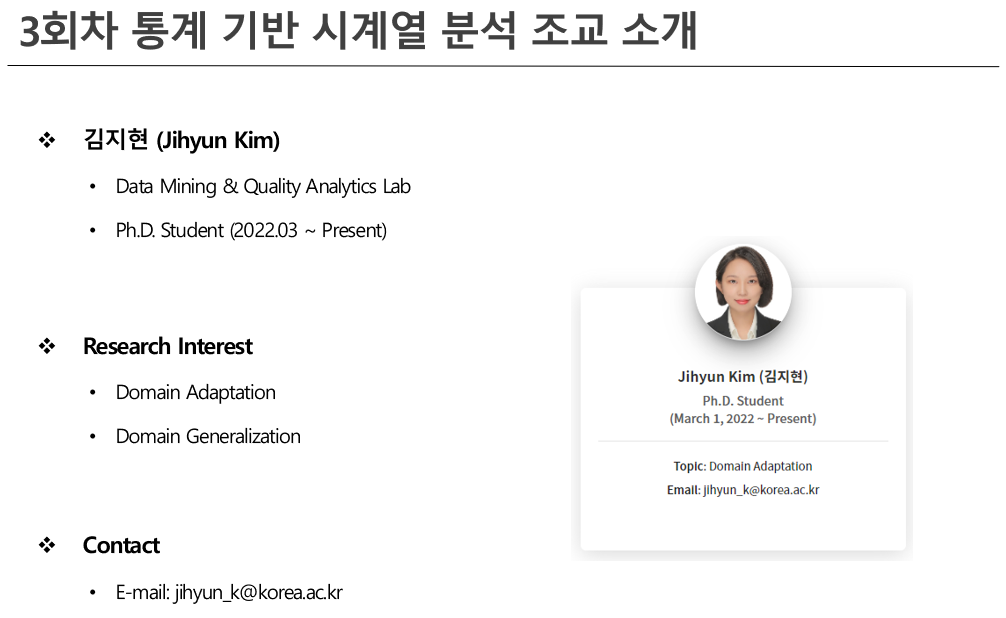

In [3]:
Image('image/img0.PNG') # 로컬 사용시
# Image('/content/2024_LGE_TimeSeries/image/img1.PNG') # colab 사용시

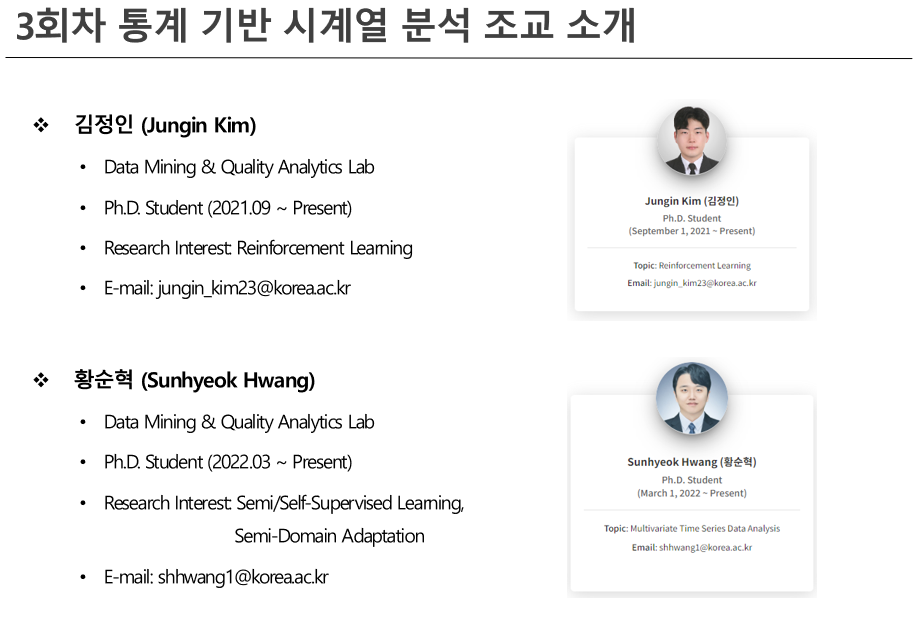

In [4]:
Image('image/img2.PNG') # 로컬 사용시
# Image('/content/2024_LGE_TimeSeries/image/img2.PNG') # colab 사용시

## 1. Binary Variable Models
- 관심 변수가 이진형(binary) 변수인 경우에 사용

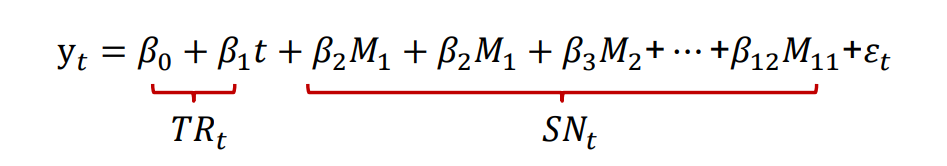

In [5]:
Image("./image/3-1.PNG")
# Image('/content/2024_LGE_TimeSeries/image/3-1.PNG') # colab

In [6]:
# 라이브러리 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [7]:
# 데이터 읽어오기
hotel_data = pd.read_csv('./dataset/example-hotel-rooms.csv')

# 코랩과 깃허브 연동하시는 분들 참고
# hotel_data = pd.read_csv('/content/2024_LGE_TimeSeries/dataset/example-hotel-rooms.csv')

In [8]:
# 데이터 잘 읽어왔는지 상단 10개 출력하기
hotel_data.head(10)

,t,y
0,1,501
1,2,488
2,3,504
3,4,578
4,5,545
5,6,632
6,7,728
7,8,725
8,9,585
9,10,542


In [9]:
# 데이터의 행과 컬럼 개수 확인하기
hotel_data.shape # (행 개수, 컬럼 개수)

(168, 2)

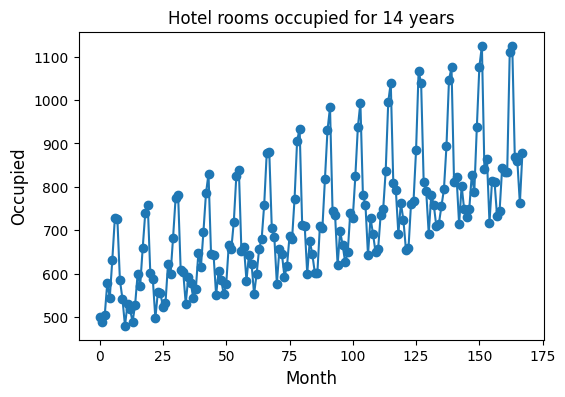

In [10]:
# 14년간 수집된 호텔 방 사용 개수 데이터
fig = plt.figure(figsize=(6,4))
plt.plot(hotel_data['y'], marker='o')
plt.title('Hotel rooms occupied for 14 years', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Occupied', fontsize=12)

plt.show()

In [11]:
hotel_data['month'] = hotel_data['t'] % 12 # % 12; 12로 나누고 난 나머지의 값
hotel_data['month'].tail(20)

148     5
149     6
150     7
151     8
152     9
153    10
154    11
155     0
156     1
157     2
158     3
159     4
160     5
161     6
162     7
163     8
164     9
165    10
166    11
167     0
Name: month, dtype: int64

In [12]:
hotel_data['month'].unique()  # 0: 1월 ~ 11: 12월

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0], dtype=int64)

### Binary Variable Models 모델링을 위해서는 아래와 같은 여러가지 Dummy, Binary Variable 생성이 필요

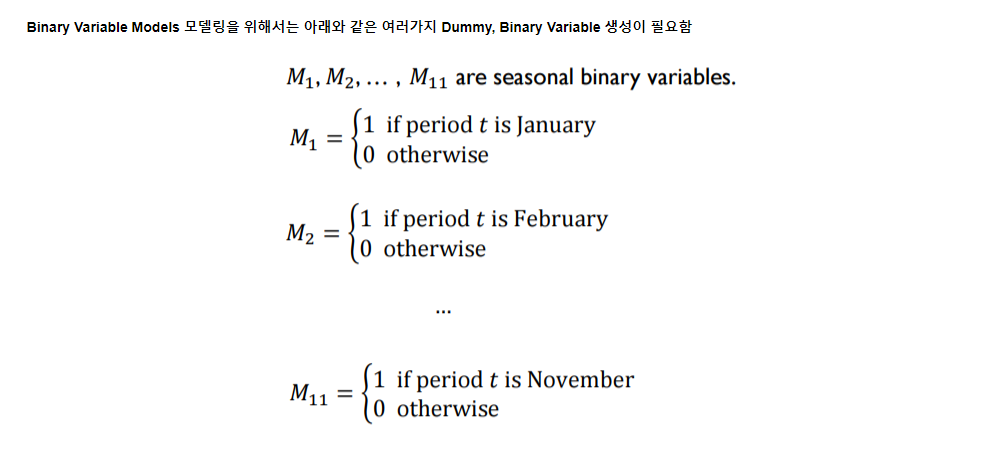

In [13]:
Image("./image/3-2.PNG")
# Image('/content/2024_LGE_TimeSeries/image/3-2.PNG') # colab

In [14]:
# 더미 Variable 생성
## drop_first 옵션: 가장 마지막에 대한 이진 변수는 효율성을 제고하여 제거할 지 안 할지?
hotel_dummy = pd.get_dummies(hotel_data['month'], drop_first=True)
hotel_dummy.rename(columns = lambda x: "m" + str(x), inplace=True) # 변수 이름 변경
hotel_dummy

,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11
0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
163,0,0,0,0,0,0,0,1,0,0,0
164,0,0,0,0,0,0,0,0,1,0,0
165,0,0,0,0,0,0,0,0,0,1,0
166,0,0,0,0,0,0,0,0,0,0,1


In [15]:
binary_hotel_data = pd.concat([hotel_data, hotel_dummy], axis=1) # column-wise 데이터 병합
binary_hotel_data

,t,y,month,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11
0,1,501,1,1,0,0,0,0,0,0,0,0,0,0
1,2,488,2,0,1,0,0,0,0,0,0,0,0,0
2,3,504,3,0,0,1,0,0,0,0,0,0,0,0
3,4,578,4,0,0,0,1,0,0,0,0,0,0,0
4,5,545,5,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,164,1124,8,0,0,0,0,0,0,0,1,0,0,0
164,165,868,9,0,0,0,0,0,0,0,0,1,0,0
165,166,860,10,0,0,0,0,0,0,0,0,0,1,0
166,167,762,11,0,0,0,0,0,0,0,0,0,0,1


In [16]:
# 타겟(종속) 변수에 대한 로그 변환 수행 (Y의 분산이 점점 커지기 때문에)
binary_hotel_data['log_y'] = np.log(binary_hotel_data['y'])
binary_hotel_data

,t,y,month,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,log_y
0,1,501,1,1,0,0,0,0,0,0,0,0,0,0,6.216606
1,2,488,2,0,1,0,0,0,0,0,0,0,0,0,6.190315
2,3,504,3,0,0,1,0,0,0,0,0,0,0,0,6.222576
3,4,578,4,0,0,0,1,0,0,0,0,0,0,0,6.359574
4,5,545,5,0,0,0,0,1,0,0,0,0,0,0,6.300786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,164,1124,8,0,0,0,0,0,0,0,1,0,0,0,7.024649
164,165,868,9,0,0,0,0,0,0,0,0,1,0,0,6.766192
165,166,860,10,0,0,0,0,0,0,0,0,0,1,0,6.756932
166,167,762,11,0,0,0,0,0,0,0,0,0,0,1,6.635947


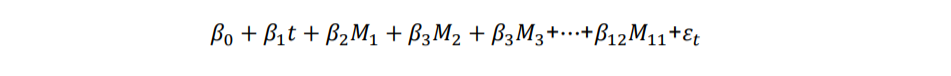

In [17]:
Image("./image/3-3.PNG")
# Image('/content/2024_LGE_TimeSeries/image/3-3.PNG') # colab

In [18]:
# Binary Variable Models 학습 및 결과물 확인
binary_hotel_model = ols('log_y ~ t+m1+m2+m3+m4+m5+m6+m7+m8+m9+m10+m11', data=binary_hotel_data).fit()
binary_hotel_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     829.0
Date:                Tue, 20 Feb 2024   Prob (F-statistic):          6.65e-134
Time:                        12:29:38   Log-Likelihood:                 391.28
No. Observations:                 168   AIC:                            -756.6
Df Residuals:                     155   BIC:                            -716.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2901      0.007    845.145      0.000       6.275       6.305
t              0.0027   3.91e-05     68.926      0.000       0.003       0.003
m1            -0.0419      0.009     -4.516      0.000      -0.060      -0.024
m2            -0.1124      0.009    -12.107      0.000      -0.131      -0.094
m3            -0.0847      0.009     -9.129      0.000      -0.103      -0.066
m4             0.0366      0.009      3.940      0.000       0.018       0.055
m5             0.0202      0.009      2.177      0.031       0.002       0.039
m6             0.1387      0.009     14.949      0.000       0.120       0.157
m7             0.2889      0.009     31.147      0.000       0.271       0.307
m8             0.3111      0.009     33.543      0.000       0.293       0.329
m9             0.0559      0.009      6.028      0.000       0.038       0.074
m10            0.0395      0.009      4.258      0.000       0.021       0.058
m11           -0.1122      0.009    -12.105      0.000      -0.131      -0.094
==============================================================================
Omnibus:                       66.458   Durbin-Watson:                   1.327
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              309.080
Skew:                          -1.405   Prob(JB):                     7.66e-68
Kurtosis:                       9.021   Cond. No.                     1.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
y_169 = binary_hotel_model.params['Intercept'] + 169*binary_hotel_model.params['t'] + binary_hotel_model.params[f'm{169%12}']
pred_169 = np.exp(y_169)  # log 변환을 취했었기 때문에 exp로 값을 원복
print(f'[Binary variables] prediction of 169 months is {pred_169:.2f}')

[Binary variables] prediction of 169 months is 815.64


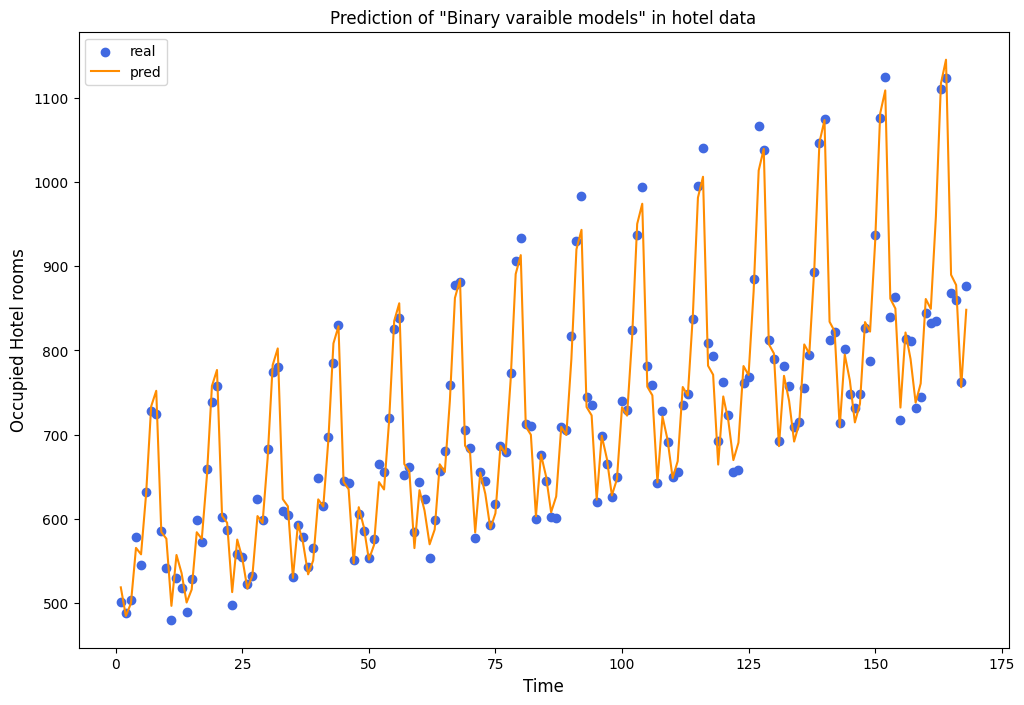

In [20]:
pred_columns = binary_hotel_data.drop(['y', 'month'], axis=1).columns # y와 month 변수를 제외한 나머지 모든 변수
pred_binary_hotel = binary_hotel_model.predict(binary_hotel_data[pred_columns])
pred_binary_hotel = np.exp(pred_binary_hotel)

# plotting predicion value and real value
fig = plt.figure(figsize=(12,8))
plt.scatter(binary_hotel_data['t'], binary_hotel_data['y'], color='royalblue', label='real')
plt.plot(binary_hotel_data['t'], pred_binary_hotel, color='darkorange' , label='pred')
plt.title('Prediction of "Binary varaible models" in hotel data', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Occupied Hotel rooms', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.legend()
plt.show()

## 2. Trigonometric Models
- 계절성을 가지는 데이터를 모델링할 때 사용하며, 시계열 데이터 내의 주기적(cycle) 변동을 캡처하기 위해서 sine과 cosine과 같은 삼각함수를 사용

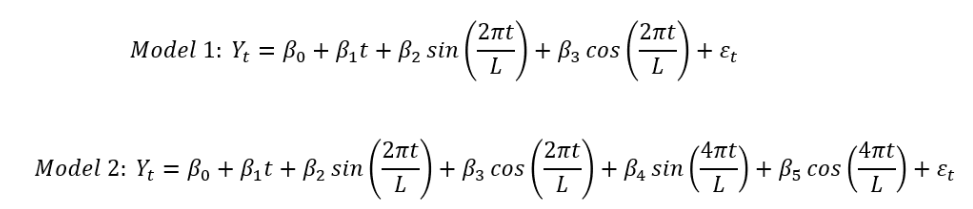

In [21]:
Image("./image/3-4.PNG")
# Image('/content/2024_LGE_TimeSeries/image/3-4.PNG') # colab

In [22]:
# trigonometric model 모델 구축을 위한 변수 생성, if standard is month, time_stand=12, if standard is day, time_stand=365 
time_stand = 12
hotel_data['sintwo'] = np.sin(2*np.pi*hotel_data['t'] / time_stand)   # model 1+ model 2
hotel_data['costwo'] = np.cos(2*np.pi*hotel_data['t'] / time_stand)   # model 1+ model 2
hotel_data['sinfour'] = np.sin(4*np.pi*hotel_data['t'] / time_stand)  # model 2
hotel_data['cosfour'] = np.cos(4*np.pi*hotel_data['t'] / time_stand)  # model 2
hotel_data['log_y'] = np.log(hotel_data['y'])  # log 변환 (y 분산이 시간에 따라 점점 커지기 떄문)

hotel_data

,t,y,month,sintwo,costwo,sinfour,cosfour,log_y
0,1,501,1,5.000000e-01,8.660254e-01,8.660254e-01,0.5,6.216606
1,2,488,2,8.660254e-01,5.000000e-01,8.660254e-01,-0.5,6.190315
2,3,504,3,1.000000e+00,6.123234e-17,1.224647e-16,-1.0,6.222576
3,4,578,4,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,6.359574
4,5,545,5,5.000000e-01,-8.660254e-01,-8.660254e-01,0.5,6.300786
...,...,...,...,...,...,...,...,...
163,164,1124,8,-8.660254e-01,-5.000000e-01,8.660254e-01,-0.5,7.024649
164,165,868,9,-1.000000e+00,-1.224956e-14,2.449913e-14,-1.0,6.766192
165,166,860,10,-8.660254e-01,5.000000e-01,-8.660254e-01,-0.5,6.756932
166,167,762,11,-5.000000e-01,8.660254e-01,-8.660254e-01,0.5,6.635947


In [23]:
# 모델 1 구축 및 확인 (Y의 분산이 점점 커지기 때문에, Y의 경우 로그 변환 수행 후 학습)
tri_hotel_model_1 = ols('log_y ~ t+sintwo+costwo', data=hotel_data).fit()
tri_hotel_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     300.5
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           2.13e-66
Time:                        12:29:38   Log-Likelihood:                 197.60
No. Observations:                 168   AIC:                            -387.2
Df Residuals:                     164   BIC:                            -374.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3360      0.012    540.512      0.000       6.313       6.359
t              0.0027      0.000     22.319      0.000       0.002       0.003
sintwo        -0.1015      0.008    -12.303      0.000      -0.118      -0.085
costwo        -0.1250      0.008    -15.165      0.000      -0.141      -0.109
==============================================================================
Omnibus:                       29.548   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.410
Skew:                           0.083   Prob(JB):                       0.0246
Kurtosis:                       1.985   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

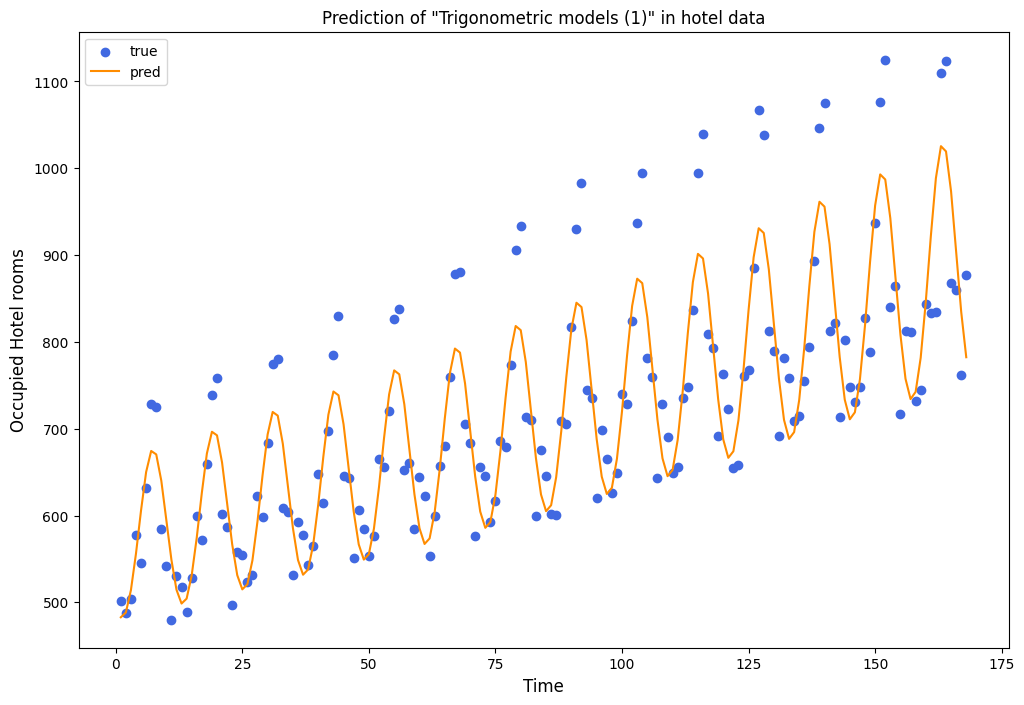

In [24]:
# 예측 결과 vs 실제 결과 비교해보기

pred_columns_tri_1 = hotel_data.drop(['y', 'month'], axis=1).columns # y와 month 변수를 제외한 나머지 변수 모음
pred_tri_1_hotel = tri_hotel_model_1.predict(hotel_data[pred_columns_tri_1]) # 예측 수행, get y_hat
pred_tri_1_hotel = np.exp(pred_tri_1_hotel)

fig = plt.figure(figsize=(12,8))
plt.scatter(hotel_data['t'], hotel_data['y'], color='royalblue', label='true')
plt.plot(hotel_data['t'], pred_tri_1_hotel, color='darkorange', label='pred')
plt.title('Prediction of "Trigonometric models (1)" in hotel data', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Occupied Hotel rooms', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.legend()
plt.show()

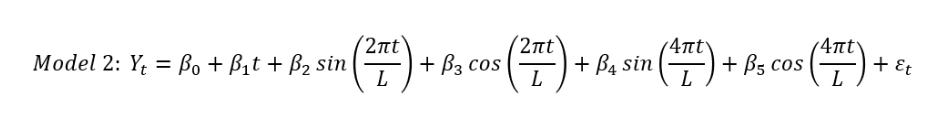

In [25]:
Image("./image/3-5.PNG")
# Image('/content/2024_LGE_TimeSeries/image/3-5.PNG') # colab

In [26]:
# 모델 2 구축 및 확인 (Y의 분산이 점점 커지기 때문에, Y의 경우 로그 변환 수행 후 학습)
tri_hotel_model_2 = ols('log_y ~ t+sintwo+costwo+sinfour+cosfour', data=hotel_data).fit()
tri_hotel_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     335.3
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           1.73e-83
Time:                        12:29:39   Log-Likelihood:                 244.45
No. Observations:                 168   AIC:                            -476.9
Df Residuals:                     162   BIC:                            -458.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3342      0.009    709.540      0.000       6.317       6.352
t              0.0027   9.17e-05     29.530      0.000       0.003       0.003
sintwo        -0.1015      0.006    -16.147      0.000      -0.114      -0.089
costwo        -0.1250      0.006    -19.923      0.000      -0.137      -0.113
sinfour        0.0667      0.006     10.620      0.000       0.054       0.079
cosfour        0.0179      0.006      2.855      0.005       0.006       0.030
==============================================================================
Omnibus:                        1.416   Durbin-Watson:                   2.570
Prob(Omnibus):                  0.493   Jarque-Bera (JB):                1.255
Skew:                           0.041   Prob(JB):                        0.534
Kurtosis:                       2.585   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# 직접 예측해보기 (one point)
y_add = np.pi*169 / time_stand
y_169_tri = tri_hotel_model_2.params['Intercept'] + 169*tri_hotel_model_2.params['t'] + np.sin(2*y_add)*tri_hotel_model_2.params['sintwo'] + np.cos(2*y_add)*tri_hotel_model_2.params['costwo'] + np.sin(4*y_add)*tri_hotel_model_2.params['sinfour'] +np.cos(4*y_add)*tri_hotel_model_2.params['cosfour']
pred_169_tri = np.exp(y_169_tri)
print(f'[Trigonometric] prediction of 169 months is {pred_169_tri:.2f}')

[Trigonometric] prediction of 169 months is 811.91


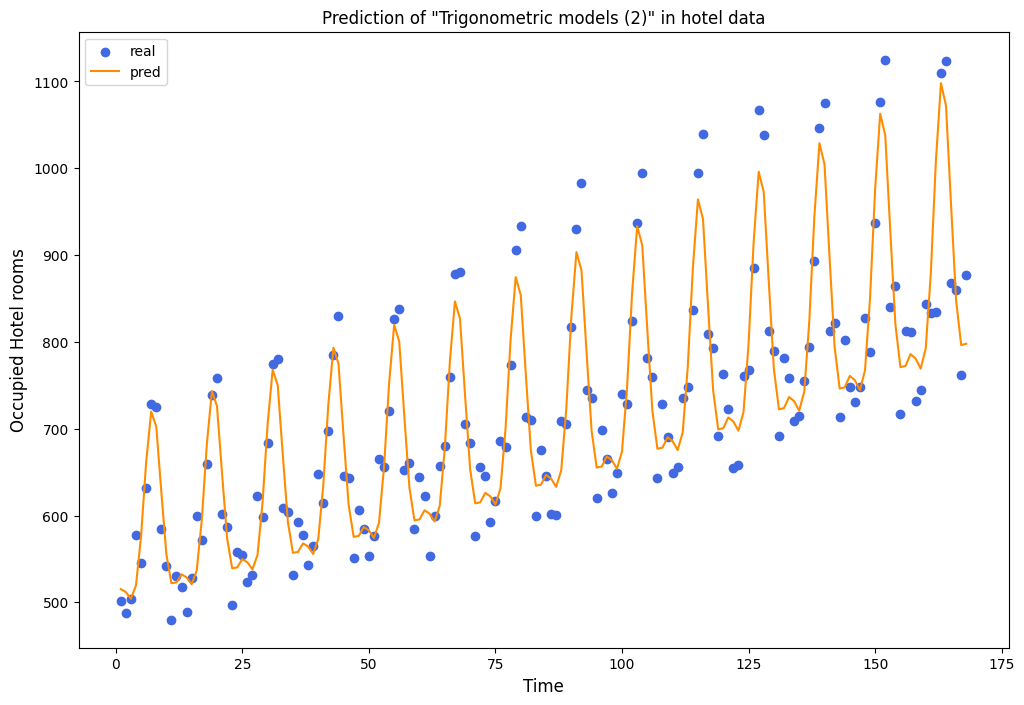

In [28]:
# 패키지 이용하여 예측하기 (전체 데이터)
pred_columns_tri_2 = hotel_data.drop(['y', 'month'], axis=1).columns
pred_tri_2_hotel = tri_hotel_model_2.predict(hotel_data[pred_columns_tri_2])
pred_tri_2_hotel = np.exp(pred_tri_2_hotel)

# 예측 결과 시각화하기
fig = plt.figure(figsize=(12,8))
plt.scatter(hotel_data['t'], hotel_data['y'], color='royalblue', label='real')
plt.plot(hotel_data['t'], pred_tri_2_hotel, color='darkorange', label='pred')
plt.title('Prediction of "Trigonometric models (2)" in hotel data', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Occupied Hotel rooms', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.legend()
plt.show()

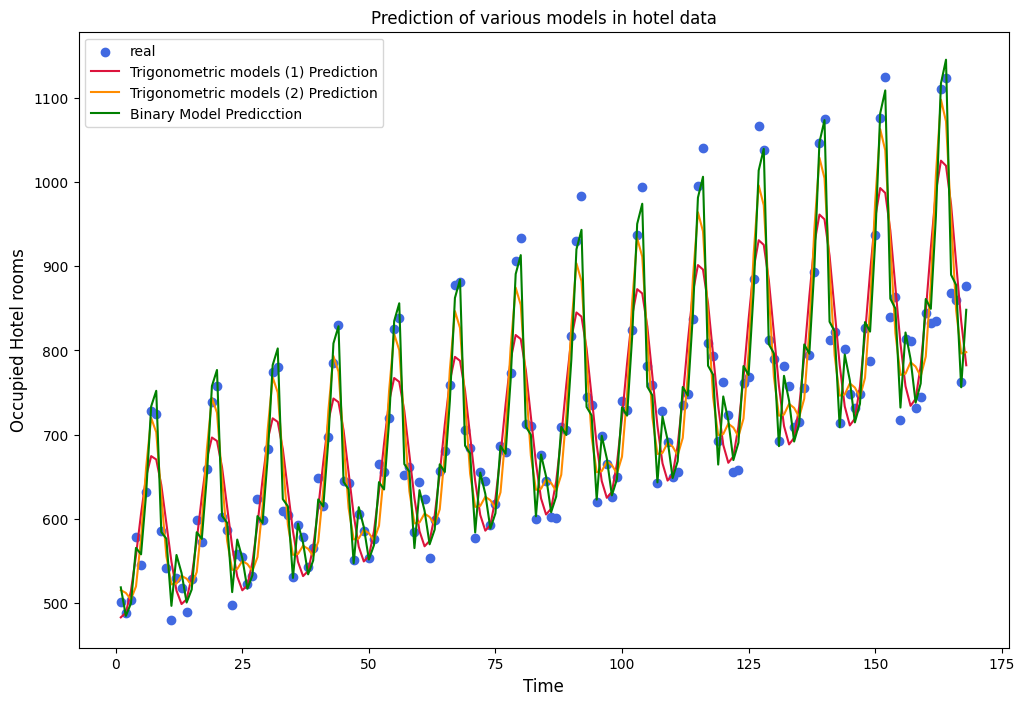

In [29]:
# Binary Model, Trigonometric models (1), (2) 성능 비교하기
fig = plt.figure(figsize=(12,8))
plt.scatter(hotel_data['t'], hotel_data['y'], color='royalblue', label='real')
plt.plot(hotel_data['t'], pred_tri_1_hotel, color='crimson', label='Trigonometric models (1) Prediction')
plt.plot(hotel_data['t'], pred_tri_2_hotel, color='darkorange', label='Trigonometric models (2) Prediction')
plt.plot(binary_hotel_data['t'], pred_binary_hotel, color='g', label='Binary Model Predicction')
plt.title('Prediction of various models in hotel data', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Occupied Hotel rooms', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.legend()
plt.show()

## 3. 평가용 지표 (연속형 수치)
- 모델의 성능 (일반적으로 예측 성능)을 정량적으로 평가하기 위한 지표
- 모델이 산출하는 output 값이 연속형(continuous)일 때는 일반적으로 MSE, MAE(MAD) 등의 지표를 이용

In [33]:
# sklearn 패키지 내부의 metrics 서브 패키지의 mean_absolute_error, mean_squared_error 함수 호출
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 아래와 같이 축약형으로도 호출 가능함
## from sklearn.metrics import mean_absolute_error as mae
## from sklearn.metrics import mean_squared_error as mse

In [30]:
# 예측 성능 지표 산출 함수 (직접 만들어 보기)
def MAD(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def MSE(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

In [34]:
# 데이터 읽기
example_data = pd.read_csv('./dataset/example-mad-mae.csv', index_col=0) # 데이터 읽을 시, 1번째 컬럼을 데이터 인덱스로 지정

# 코랩과 깃허브 연동하시는 분들
## example_data = pd.read_csv('/content/2024_LGE_TimeSeries/dataset/example-mad-mae.csv', index_col=0) # 데이터 읽을 시, 1번째 컬럼을 데이터 인덱스로 지정

In [35]:
# 데이터 상단 5개 출력하여 잘 읽혔는지 확인
example_data.head(5)

,actual_y,pred_y
0,60,59
1,64,65
2,67,73


In [36]:
# 데이터 컬럼명 확인하기
example_data.columns

Index(['actual_y', 'pred_y'], dtype='object')

### MAE(MAD); 직접 만든 함수와 패키지 함수로 결과 비교

In [37]:
# MAD(MAE)
mad1 = MAD(example_data['actual_y'], example_data['pred_y'])
print(f'MAD by coding = {mad1:.2f}') # 소숫점(float)을 두번째 자리까지 출력
mad2 = mean_absolute_error(example_data['actual_y'], example_data['pred_y'])
print(f'MAD in package = {mad2:.2f}') # 소숫점(float)을 두번째 자리까지 출력

MAD by coding = 2.67
MAD in package = 2.67


### MSE; 직접 만든 함수와 패키지 함수로 결과 비교

In [38]:
# calculate a MSE
mse1 = MSE(example_data['actual_y'], example_data['pred_y'])
print(f'MSE by coding = {mse1:.2f}')
mse2 = mean_squared_error(example_data['actual_y'], example_data['pred_y'])
print(f'MSE in package = {mse2:.2f}')

MSE by coding = 12.67
MSE in package = 12.67


### Real-world hotel data에 대한 모델 성능 평가

In [31]:
# 모델별 예측 성능 지표 산출하기 MAD 기준
mad_bin = MAD(hotel_data['y'], pred_binary_hotel )
print(f'MAD of binary variables models = {mad_bin:.2f}')
mad_tri_1 = MAD(hotel_data['y'], pred_tri_1_hotel)
print(f'MAD of trigonometric models (1) = {mad_tri_1:.2f}')
mad_tri_2 = MAD(hotel_data['y'], pred_tri_2_hotel)
print(f'MAD of trigonometric models (2)  = {mad_tri_2:.2f}')

MAD of binary variables models = 12.65
MAD of trigonometric models (1) = 47.17
MAD of trigonometric models (2)  = 34.71


In [32]:
# # 모델별 예측 성능 지표 산출하기 MSE 기준
mse_bin = MSE(hotel_data['y'], pred_binary_hotel )
print(f'MSE of binary variables models = {mse_bin:.2f}')
mse_tri_1 = MSE(hotel_data['y'], pred_tri_1_hotel)
print(f'MSE of trigonometric models (1) = {mse_tri_1:.2f}')
mse_tri_2 = MSE(hotel_data['y'], pred_tri_2_hotel)
print(f'MSE of trigonometric models (2)  = {mse_tri_2:.2f}')

MSE of binary variables models = 326.40
MSE of trigonometric models (1) = 3401.63
MSE of trigonometric models (2)  = 1809.61
